**Author :** SUN Lauria

# Challenge IMA205 : Cardiac Pathology Prediction

## Importing librairies 

In [64]:
import os
import cv2
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.morphology import binary_fill_holes
from nibabel import concat_images
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import classification_report, accuracy_score

%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)


## 1. Quick overview of the dataset : Data Visualization 

### 1.1 Importing data

In [2]:
# Read data
Working_directory = "./ima205-challenge-2023/"
df_train = pd.read_csv(Working_directory + 'metaDataTrain.csv')  
df_test = pd.read_csv(Working_directory + 'metaDataTest.csv')

In [3]:
df_train

,Id,Category,Height,Weight
0,1,2,184.0,95.0
1,2,2,160.0,70.0
2,3,2,165.0,77.0
3,4,2,159.0,46.0
4,5,2,165.0,77.0
...,...,...,...,...
95,96,4,186.0,76.0
96,97,4,187.0,82.0
97,98,4,167.0,50.0
98,99,4,180.0,80.0


In [4]:
df_test.head()

,Id,Height,Weight
0,101,167.0,89.0
1,102,137.0,35.0
2,103,167.0,116.0
3,104,160.0,98.0
4,105,174.0,64.0


In [5]:
# Create a dataFrame df_coef and store the accuracy coefficients of the different estimated model
df_coef = pd.DataFrame()

### 1.2 Visualizing data

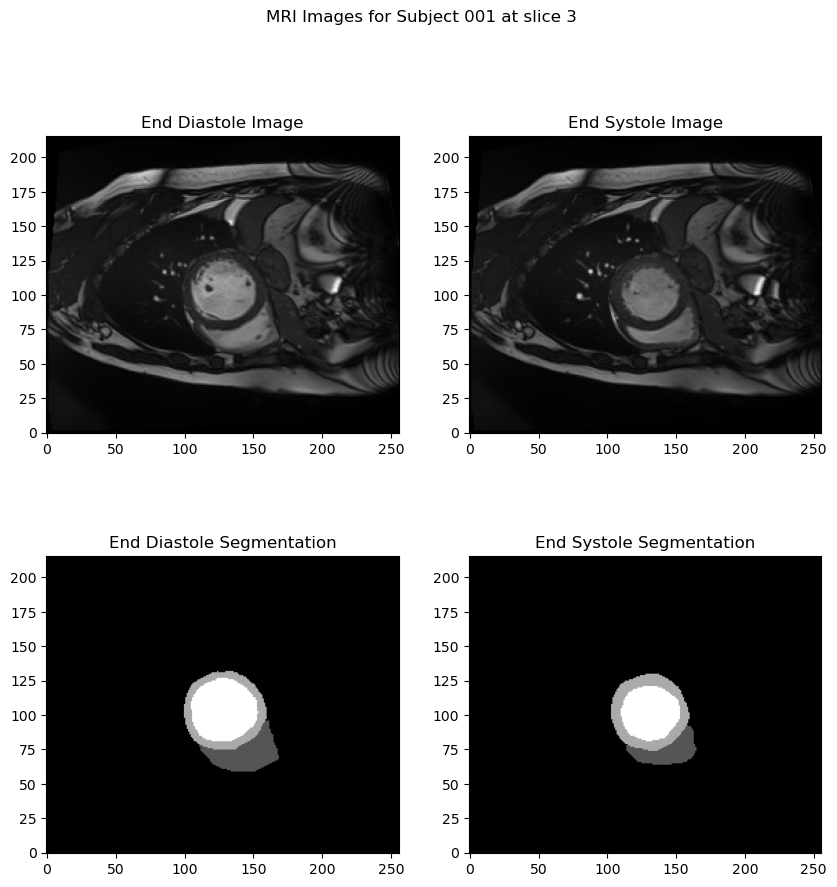

Shape of End Diastole Segmentation Data: (216, 256, 10)
Shape of End Systole Segmentation Data: (216, 256, 10)


In [6]:
file_idx = 1 # Patient id
i = 3 # Slice of the images 

# Load end diastole segmentation
ed_seg_path = "{}/Train/{:03d}/{:03d}_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
ed_seg = nib.load(ed_seg_path)

# Load end diastole image
ed_im_path = "{}/Train/{:03d}/{:03d}_ED.nii".format(
    Working_directory, file_idx, file_idx)
ed_im = nib.load(ed_im_path)

# Load end systole segmentation
es_seg_path = "{}/Train/{:03d}/{:03d}_ES_seg.nii".format(
    Working_directory, file_idx, file_idx)
es_seg = nib.load(es_seg_path)

# Load end systole image
es_im_path = "{}/Train/{:03d}/{:03d}_ES.nii".format(
    Working_directory, file_idx, file_idx)
es_im = nib.load(es_im_path)

# Get the data arrays for the images and segmentations
ed_data = ed_im.get_fdata()
es_data = es_im.get_fdata()
ed_seg_data = ed_seg.get_fdata().astype(np.int32)
es_seg_data = es_seg.get_fdata().astype(np.int32)

# Create a figure with 4 subplots to show the images and segmentations
fig, axs = plt.subplots(2, 2, figsize=(10,10))

# Show the end diastole image in the top left subplot
axs[0, 0].imshow(ed_data[:, :, i], cmap='gray', origin='lower')
axs[0, 0].set_title("End Diastole Image")

# Show the end systole image in the top right subplot
axs[0, 1].imshow(es_data[:, :, i], cmap='gray', origin='lower')
axs[0, 1].set_title("End Systole Image")

# Show the end diastole segmentation in the bottom left subplot
axs[1, 0].imshow(ed_seg_data[:, :, i], cmap='gray', origin='lower')
axs[1, 0].set_title("End Diastole Segmentation")

# Show the end systole segmentation in the bottom right subplot
axs[1, 1].imshow(es_seg_data[:, :, i], cmap='gray', origin='lower')
axs[1, 1].set_title("End Systole Segmentation")

# Set the title of the figure
fig.suptitle("MRI Images for Subject {:03d} at slice {}".format(file_idx,i))

# Show the figure
plt.show()

# Print the shape of the end diastole segmentation data array
print("Shape of End Diastole Segmentation Data: {}".format(ed_seg_data.shape))
print("Shape of End Systole Segmentation Data: {}".format(es_seg_data.shape))

***
## II. Pre-processing : segmentation of test set

In [12]:
n_files = 151

# Loop over each file
for file_idx in range(101, n_files):

    # Create an empty list to store the 2D image data
    myo_ed_seg_data_list = []
    myo_es_seg_data_list = []

    # Load the image from the file
    init_partial_ed_seg_path = "{}/Test/{:03d}/{:03d}_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
    init_partial_ed_seg = nib.load(init_partial_ed_seg_path)
    init_partial_es_seg_path = "{}/Test/{:03d}/{:03d}_ES_seg.nii".format(
        Working_directory, file_idx, file_idx)
    init_partial_es_seg = nib.load(init_partial_es_seg_path)

    init_partial_ed_seg_data = init_partial_ed_seg.get_fdata().astype(np.int32)
    init_partial_es_seg_data = init_partial_es_seg.get_fdata().astype(np.int32)

    partial_ed_seg_data = (init_partial_ed_seg_data == 2)
    partial_es_seg_data = (init_partial_es_seg_data == 2)

    for i, j in zip(range(partial_ed_seg_data.shape[2]), range(partial_es_seg_data.shape[2])):

        t_myo_ed_seg_data = partial_ed_seg_data[:, :, i]
        t_myo_es_seg_data = partial_es_seg_data[:, :, j]

        # Apply binary_fill_holes to fill the partial segmentation
        myo_ed_seg_data = binary_fill_holes(t_myo_ed_seg_data).astype(np.uint8)
        myo_es_seg_data = binary_fill_holes(t_myo_es_seg_data).astype(np.uint8)

        myo_ed_seg_data -= t_myo_ed_seg_data
        myo_es_seg_data -= t_myo_es_seg_data

        # Append the 2D image data to the list
        myo_ed_seg_data_list.append(myo_ed_seg_data)
        myo_es_seg_data_list.append(myo_es_seg_data)

    # Concatenate the 2D image data list into a 3D image data array
    myo_ed_seg_data = np.dstack(myo_ed_seg_data_list)
    myo_es_seg_data = np.dstack(myo_es_seg_data_list)

    # Create a new NIfTI image with the 3D image data
    myo_ed_seg_img = nib.Nifti1Image(
        myo_ed_seg_data, init_partial_ed_seg.affine, init_partial_ed_seg.header)
    myo_es_seg_img = nib.Nifti1Image(
        myo_es_seg_data, init_partial_es_seg.affine, init_partial_es_seg.header)

    # Save the new image to the same directory as the original partial segmentation files
    myo_ed_seg_path = "{}/Test/{:03d}/{:03d}_myo_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
    nib.save(myo_ed_seg_img, myo_ed_seg_path)
    myo_es_seg_path = "{}/Test/{:03d}/{:03d}_myo_ES_seg.nii".format(
        Working_directory, file_idx, file_idx)
    nib.save(myo_es_seg_img, myo_es_seg_path)

    # Create an empty list to store the 2D image data
    myo_ed_seg_data_list = []
    partial_ed_seg_data_list = []
    myo_es_seg_data_list = []
    partial_es_seg_data_list = []

    myo_ed_seg = nib.load(myo_ed_seg_path)
    myo_es_seg = nib.load(myo_es_seg_path)

    partial_ed_seg_data = init_partial_ed_seg.get_fdata().astype(np.int32)
    myo_ed_seg_data = myo_ed_seg.get_fdata().astype(np.int32)
    partial_es_seg_data = init_partial_es_seg.get_fdata().astype(np.int32)
    myo_es_seg_data = myo_es_seg.get_fdata().astype(np.int32)

    # Combine the two segmentations
    full_ed_seg_data = np.zeros_like(partial_ed_seg_data)
    full_ed_seg_data[myo_ed_seg_data == 1] = 3
    full_ed_seg_data[partial_ed_seg_data == 2] = 2
    full_ed_seg_data[partial_ed_seg_data == 1] = 1
    full_es_seg_data = np.zeros_like(partial_es_seg_data)
    full_es_seg_data[myo_es_seg_data == 1] = 3
    full_es_seg_data[partial_es_seg_data == 2] = 2
    full_es_seg_data[partial_es_seg_data == 1] = 1

    # Create a new NIfTI image with the 3D image data
    full_ed_seg_img = nib.Nifti1Image(
        full_ed_seg_data, init_partial_ed_seg.affine, init_partial_ed_seg.header)
    full_es_seg_img = nib.Nifti1Image(
        full_es_seg_data, init_partial_es_seg.affine, init_partial_es_seg.header)

    # Save the new image to the same directory as the original partial segmentation files
    full_ed_seg_path = "{}/Test/{:03d}/{:03d}_full_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
    nib.save(full_ed_seg_img, full_ed_seg_path)
    full_es_seg_path = "{}/Test/{:03d}/{:03d}_full_ES_seg.nii".format(
        Working_directory, file_idx, file_idx)
    nib.save(full_es_seg_img, full_es_seg_path)

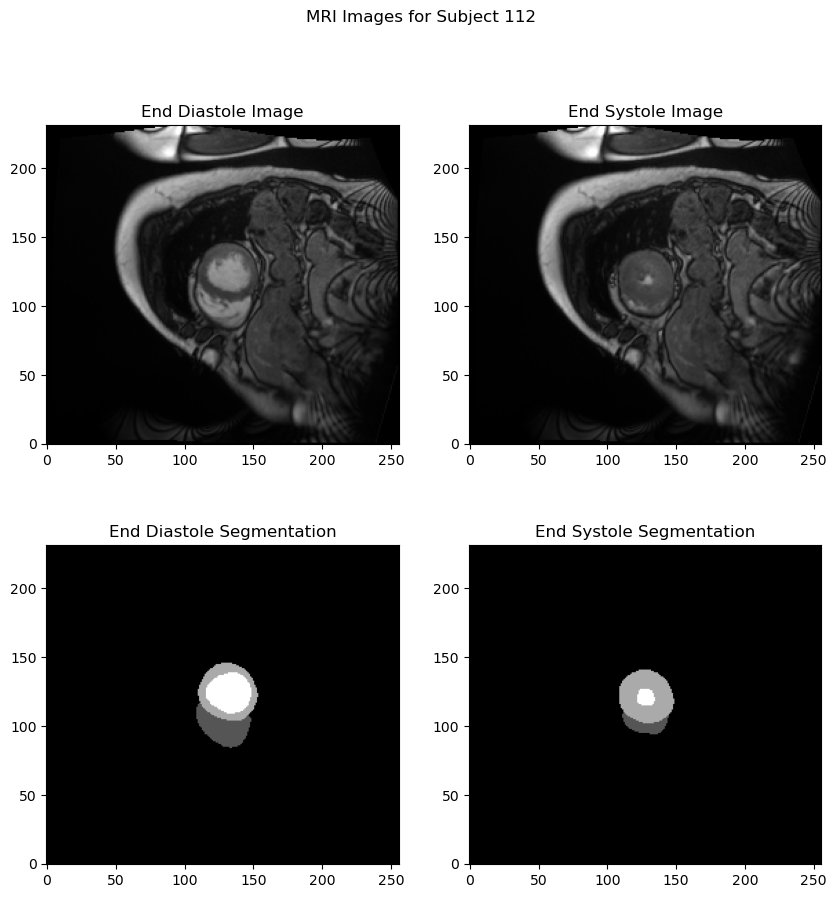

Shape of End Diastole Segmentation Data: (232, 256, 9)
Shape of End Systole Segmentation Data: (232, 256, 9)


In [13]:
file_idx = 112 # Patient id
i = 5 # Slice of the images 

# Load end diastole segmentation
ed_seg_path = "{}/Test/{:03d}/{:03d}_full_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
ed_seg = nib.load(ed_seg_path)

# Load end diastole image
ed_im_path = "{}/Test/{:03d}/{:03d}_ED.nii".format(
    Working_directory, file_idx, file_idx)
ed_im = nib.load(ed_im_path)

# Load end systole segmentation
es_seg_path = "{}/Test/{:03d}/{:03d}_full_ES_seg.nii".format(
    Working_directory, file_idx, file_idx)
es_seg = nib.load(es_seg_path)

# Load end systole image
es_im_path = "{}/Test/{:03d}/{:03d}_ES.nii".format(
    Working_directory, file_idx, file_idx)
es_im = nib.load(es_im_path)

# Get the data arrays for the images and segmentations
ed_data = ed_im.get_fdata()
es_data = es_im.get_fdata()
ed_seg_data = ed_seg.get_fdata().astype(np.int32)
es_seg_data = es_seg.get_fdata().astype(np.int32)

# Create a figure with 4 subplots to show the images and segmentations
fig, axs = plt.subplots(2, 2, figsize=(10,10))

# Show the end diastole image in the top left subplot
axs[0, 0].imshow(ed_data[:, :, i], cmap='gray', origin='lower')
axs[0, 0].set_title("End Diastole Image")

# Show the end systole image in the top right subplot
axs[0, 1].imshow(es_data[:, :, i], cmap='gray', origin='lower')
axs[0, 1].set_title("End Systole Image")

# Show the end diastole segmentation in the bottom left subplot
axs[1, 0].imshow(ed_seg_data[:, :, i], cmap='gray', origin='lower')
axs[1, 0].set_title("End Diastole Segmentation")

# Show the end systole segmentation in the bottom right subplot
axs[1, 1].imshow(es_seg_data[:, :, i], cmap='gray', origin='lower')
axs[1, 1].set_title("End Systole Segmentation")

# Set the title of the figure
fig.suptitle("MRI Images for Subject {:03d}".format(file_idx))

# Show the figure
plt.show()

# Print the shape of the end diastole segmentation data array
print("Shape of End Diastole Segmentation Data: {}".format(ed_seg_data.shape))
print("Shape of End Systole Segmentation Data: {}".format(es_seg_data.shape))

***
## 3. Extraction of features

### 3.1 Functions for feature extraction

In [14]:
def thickness_myo(img):
    img = img.astype(np.uint8)
    thickness = np.zeros(img.shape[2])
    for k in range(img.shape[2]):
        dist_transform = cv2.distanceTransform(
            img[:, :, k], cv2.DIST_L2, 5)
        thickness[k] = dist_transform.max() - dist_transform.min()
    return thickness

In [15]:
def volume(data, img):
    volumes = np.zeros(len(img.shape)+1)
    for label_val in range(1, len(img.shape)+1):
        volumes[label_val] = np.sum(
            data == label_val) * np.prod(img.header.get_zooms())
    return volumes

In [16]:
def ejection_fraction(es_data, es_img, ed_data, ed_img):
    ef = np.zeros(3)
    ed_lv_volume = volume(ed_data, ed_img)[
        3] + volume(ed_data, ed_img)[2] + volume(ed_data, ed_img)[1]
    es_lv_volume = volume(es_data, es_img)[
        3] + volume(es_data, es_img)[2] + volume(es_data, es_img)[1]
    ef_global = (ed_lv_volume - es_lv_volume) / ed_lv_volume
    lv_ef = (volume(ed_data, ed_img)[
             3] - volume(es_data, es_img)[3]) / volume(ed_data, ed_img)[3]
    rv_ef = (volume(ed_data, ed_img)[
             1] - volume(es_data, es_img)[1]) / volume(ed_data, ed_img)[1]
    ef=[ef_global,lv_ef,rv_ef]
    return ef

In [17]:
def circularity(data, img, j):
    max_circum_list = []
    min_circum_list = []

    for i in range(data.shape[2]):
        
        # Calculate circularity and circumference of RVC and Myocardium
        # RVC = 2, Myocardium = 1
        mask = (data[:, :, i] == j)
        contours, hierarchy = cv2.findContours(
            (mask.astype(np.uint8)*255), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        max_circumference = 0
        min_circumference = np.inf
        total_circularity = 0
        for contour in contours:
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, closed=True)
            if (perimeter != 0):
                circularity = 4 * np.pi * area / (perimeter ** 2)
            else:
                circularity = 0
            max_circumference = max(max_circumference, perimeter)
            min_circumference = min(min_circumference, perimeter)
            total_circularity += circularity
        max_circum_list.append(max_circumference)
        min_circum_list.append(min_circumference)
        
    return [max_circum_list, min_circum_list]

### 3.2 Train set

In [18]:
# Set the last patient id
n_files = 101

# Loop over each file/patient
for file_idx in range(1, n_files):
    
    ed_seg_path = "{}/Train/{:03d}/{:03d}_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
    ed_seg = nib.load(ed_seg_path)

    ed_im_path = "{}/Train/{:03d}/{:03d}_ED.nii".format(
        Working_directory, file_idx, file_idx)
    ed_im = nib.load(ed_seg_path)

    es_seg_path = "{}/Train/{:03d}/{:03d}_ES_seg.nii".format(
        Working_directory, file_idx, file_idx)
    es_seg = nib.load(es_seg_path)

    es_im_path = "{}/Train/{:03d}/{:03d}_ES.nii".format(
        Working_directory, file_idx, file_idx)
    es_im = nib.load(es_im_path)

    # Get image data as NumPy arrays
    ed_data = ed_im.get_fdata()
    es_data = es_im.get_fdata()
    ed_seg_data = ed_seg.get_fdata().astype(np.int32)
    es_seg_data = es_seg.get_fdata().astype(np.int32)

    # Store results in a DataFrame
    df_train.loc[file_idx-1,
                 'End diastole volume (RV)'] = volume(ed_seg_data, ed_seg)[1]
    df_train.loc[file_idx-1,
                 'End diastole volume (LV)'] = volume(ed_seg_data, ed_seg)[3]
    df_train.loc[file_idx-1,
                 'End diastole volume (Myocardium)'] = volume(ed_seg_data, ed_seg)[2]
    df_train.loc[file_idx-1,
                 'End systole volume (RV)'] = volume(es_seg_data, es_seg)[1]
    df_train.loc[file_idx-1,
                 'End systole volume (LV)'] = volume(es_seg_data, es_seg)[3]
    df_train.loc[file_idx-1,
                 'End systole volume (Myocardium)'] = volume(es_seg_data, es_seg)[2]
    df_train.loc[file_idx-1,
                 'Myocardial thickness Mean (ED)'] = np.mean(thickness_myo(ed_seg_data))
    df_train.loc[file_idx-1,
                 'Myocardial thickness Max (ED)'] = np.max(thickness_myo(ed_seg_data))
    df_train.loc[file_idx-1,
                 'Myocardial thickness Min (ED)'] = np.min(thickness_myo(ed_seg_data))
    df_train.loc[file_idx-1,
                 'Myocardial thickness Std (ED)'] = np.std(thickness_myo(ed_seg_data))
    df_train.loc[file_idx-1,
                 'Myocardial thickness Mean (ES)'] = np.mean(thickness_myo(es_seg_data))
    df_train.loc[file_idx-1,
                 'Myocardial thickness Max (ES)'] = np.max(thickness_myo(es_seg_data))
    df_train.loc[file_idx-1,
                 'Myocardial thickness Min (ES)'] = np.min(thickness_myo(es_seg_data))
    df_train.loc[file_idx-1,
                 'Myocardial thickness Std (ES)'] = np.std(thickness_myo(es_seg_data))
    df_train.loc[file_idx-1, 'Ejection fraction (Global)'] = ejection_fraction(
        es_seg_data, es_seg, ed_seg_data, ed_seg)[0]
    df_train.loc[file_idx-1, 'Ejection fraction (LV)'] = ejection_fraction(
        es_seg_data, es_seg, ed_seg_data, ed_seg)[1]
    df_train.loc[file_idx-1, 'Ejection fraction (RV)'] = ejection_fraction(
        es_seg_data, es_seg, ed_seg_data, ed_seg)[2]
    df_train.loc[file_idx-1,
                 'Volume Ratio (Myocardium)'] = volume(ed_seg_data, ed_seg)[2]/volume(es_seg_data, es_seg)[2]
    df_train.loc[file_idx-1, 'Volume Ratio (LV)'] = volume(ed_seg_data, ed_seg)[3]/volume(es_seg_data, es_seg)[3]
    df_train.loc[file_idx-1, 'Volume Ratio (RV)'] = volume(ed_seg_data, ed_seg)[1]/volume(es_seg_data, es_seg)[1]
    df_train.loc[file_idx-1,
                 'Volume Ratio (LV/RV, ED)'] = volume(ed_seg_data, ed_seg)[3]/volume(ed_seg_data, ed_seg)[1]
    df_train.loc[file_idx-1,
                 'Volume Ratio (LV/RV, ES)'] = volume(es_seg_data, es_seg)[3]/volume(es_seg_data, es_seg)[1]
    df_train.loc[file_idx-1,
                 'Volume Ratio (LV/Myo, ED)'] = volume(ed_seg_data, ed_seg)[2]/volume(ed_seg_data, ed_seg)[3]
    df_train.loc[file_idx-1,
                 'Volume Ratio (LV/Myo, ES)'] = volume(es_seg_data, es_seg)[2]/volume(es_seg_data, es_seg)[3]
    df_train.loc[file_idx-1,
                 'RVC max circumference'] = np.max(circularity(ed_seg_data, ed_seg, 1)[0])
    df_train.loc[file_idx-1,
                 'RVC min circumference'] = np.min(circularity(ed_seg_data, ed_seg, 1)[1])
    df_train.loc[file_idx-1,
                 'Myocardium max circumference'] = np.max(circularity(ed_seg_data, ed_seg, 2)[0])
    df_train.loc[file_idx-1,
                 'Myocardium min circumference'] = np.min(circularity(ed_seg_data, ed_seg, 2)[1])

In [19]:
df_train

,Id,Category,Height,Weight,End diastole volume (RV),End diastole volume (LV),End diastole volume (Myocardium),End systole volume (RV),End systole volume (LV),End systole volume (Myocardium),...,Volume Ratio (LV),Volume Ratio (RV),"Volume Ratio (LV/RV, ED)","Volume Ratio (LV/RV, ES)","Volume Ratio (LV/Myo, ED)","Volume Ratio (LV/Myo, ES)",RVC max circumference,RVC min circumference,Myocardium max circumference,Myocardium min circumference
0,1,2,184.0,95.0,139721.679688,295507.812500,164257.812500,59545.898438,225610.351562,195068.359375,...,1.309815,2.346453,2.114975,3.788848,0.555849,0.864625,186.610172,30.142135,193.923880,100.083260
1,2,2,160.0,70.0,94432.067871,265744.400024,160433.578491,28823.089600,188303.375244,192565.155029,...,1.411257,3.276265,2.814133,6.533074,0.603714,1.022633,169.781745,26.727922,213.237588,77.012193
2,3,2,165.0,77.0,192333.984375,276708.984375,191845.703125,174584.960938,241088.867188,201074.218750,...,1.147747,1.101664,1.438690,1.380926,0.693312,0.834025,181.195958,73.698484,187.438599,75.355338
3,4,2,159.0,46.0,106264.114380,260847.091675,168452.453613,84543.991089,226472.473145,174957.275391,...,1.151783,1.256909,2.454705,2.678753,0.645790,0.772532,177.539104,71.941125,206.409161,69.698484
4,5,2,165.0,77.0,170463.867188,290797.119141,201392.578125,74553.222656,224094.726562,232261.962891,...,1.297653,2.286472,1.705916,3.005836,0.692554,1.036445,206.166520,37.798989,219.722869,83.597979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,4,186.0,76.0,284093.103704,152260.992193,116967.021618,217681.544952,74905.895834,115055.795774,...,2.032697,1.305086,0.535955,0.344108,0.768201,1.536005,189.338093,72.769552,143.781744,61.455843
96,97,4,187.0,82.0,208836.737221,124381.027813,93511.617722,129096.269611,49664.275764,110345.471619,...,2.504437,1.617682,0.595590,0.384707,0.751816,2.221828,211.338093,70.526911,148.953318,83.840619
97,98,4,167.0,50.0,164656.250000,93843.750000,93625.000000,161500.000000,41187.500000,102171.875000,...,2.278452,1.019543,0.569937,0.255031,0.997669,2.480653,225.965510,103.497473,177.823375,89.497473
98,99,4,180.0,80.0,200365.734255,140401.102558,92585.646441,136638.365765,74058.950872,92234.882841,...,1.895802,1.466394,0.700724,0.542007,0.659437,1.245425,164.953318,28.142135,134.124890,37.798989


### 3.2 Test set

In [20]:
# Set the last patient id
n_files = 151

# Loop over each file/patient
for file_idx in range(101, n_files):
    
    ed_seg_path = "{}/Test/{:03d}/{:03d}_full_ED_seg.nii".format(
        Working_directory, file_idx, file_idx)
    ed_seg = nib.load(ed_seg_path)

    ed_im_path = "{}/Test/{:03d}/{:03d}_ED.nii".format(
        Working_directory, file_idx, file_idx)
    ed_im = nib.load(ed_seg_path)

    es_seg_path = "{}/Test/{:03d}/{:03d}_full_ES_seg.nii".format(
        Working_directory, file_idx, file_idx)
    es_seg = nib.load(es_seg_path)

    es_im_path = "{}/Test/{:03d}/{:03d}_ES.nii".format(
        Working_directory, file_idx, file_idx)
    es_im = nib.load(es_im_path)

    # Get image data as NumPy arrays
    ed_data = ed_im.get_fdata()
    es_data = es_im.get_fdata()
    ed_seg_data = ed_seg.get_fdata().astype(np.int32)
    es_seg_data = es_seg.get_fdata().astype(np.int32)

    # Store results in a DataFrame
    df_test.loc[file_idx-101,
                'End diastole volume (RV)'] = volume(ed_seg_data, ed_seg)[1]
    df_test.loc[file_idx-101,
                'End diastole volume (LV)'] = volume(ed_seg_data, ed_seg)[3]
    df_test.loc[file_idx-101,
                'End diastole volume (Myocardium)'] = volume(ed_seg_data, ed_seg)[2]
    df_test.loc[file_idx-101,
                'End systole volume (RV)'] = volume(es_seg_data, es_seg)[1]
    df_test.loc[file_idx-101,
                'End systole volume (LV)'] = volume(es_seg_data, es_seg)[3]
    df_test.loc[file_idx-101,
                'End systole volume (Myocardium)'] = volume(es_seg_data, es_seg)[2]
    df_test.loc[file_idx-101,
                'Myocardial thickness Mean (ED)'] = np.mean(thickness_myo(ed_seg_data))
    df_test.loc[file_idx-101,
                'Myocardial thickness Max (ED)'] = np.max(thickness_myo(ed_seg_data))
    df_test.loc[file_idx-101,
                'Myocardial thickness Min (ED)'] = np.min(thickness_myo(ed_seg_data))
    df_test.loc[file_idx-101,
                'Myocardial thickness Std (ED)'] = np.std(thickness_myo(ed_seg_data))
    df_test.loc[file_idx-101,
                'Myocardial thickness Mean (ES)'] = np.mean(thickness_myo(es_seg_data))
    df_test.loc[file_idx-101,
                'Myocardial thickness Max (ES)'] = np.max(thickness_myo(es_seg_data))
    df_test.loc[file_idx-101,
                'Myocardial thickness Min (ES)'] = np.min(thickness_myo(es_seg_data))
    df_test.loc[file_idx-101,
                'Myocardial thickness Std (ES)'] = np.std(thickness_myo(es_seg_data))
    df_test.loc[file_idx-101, 'Ejection fraction (Global)'] = ejection_fraction(
        es_seg_data, es_seg, ed_seg_data, ed_seg)[0]
    df_test.loc[file_idx-101, 'Ejection fraction (LV)'] = ejection_fraction(
        es_seg_data, es_seg, ed_seg_data, ed_seg)[1]
    df_test.loc[file_idx-101, 'Ejection fraction (RV)'] = ejection_fraction(
        es_seg_data, es_seg, ed_seg_data, ed_seg)[2]
    df_test.loc[file_idx-101,
                 'Volume Ratio (Myocardium)'] = volume(ed_seg_data, ed_seg)[2]/volume(es_seg_data, es_seg)[2]
    df_test.loc[file_idx-101, 'Volume Ratio (LV)'] = volume(ed_seg_data, ed_seg)[3]/volume(es_seg_data, es_seg)[3]
    df_test.loc[file_idx-101, 'Volume Ratio (RV)'] = volume(ed_seg_data, ed_seg)[1]/volume(es_seg_data, es_seg)[1]
    df_test.loc[file_idx-101,
                 'Volume Ratio (LV/RV, ED)'] = volume(ed_seg_data, ed_seg)[3]/volume(ed_seg_data, ed_seg)[1]
    df_test.loc[file_idx-101,
                 'Volume Ratio (LV/RV, ES)'] = volume(es_seg_data, es_seg)[3]/volume(es_seg_data, es_seg)[1]
    df_test.loc[file_idx-101,
                 'Volume Ratio (LV/Myo, ED)'] = volume(ed_seg_data, ed_seg)[2]/volume(ed_seg_data, ed_seg)[3]
    df_test.loc[file_idx-101,
                 'Volume Ratio (LV/Myo, ES)'] = volume(es_seg_data, es_seg)[2]/volume(es_seg_data, es_seg)[3]
    df_test.loc[file_idx-101,
                'RVC max circumference'] = np.max(circularity(ed_seg_data, ed_seg, 1)[0])
    df_test.loc[file_idx-101,
                'RVC min circumference'] = np.min(circularity(ed_seg_data, ed_seg, 1)[1])
    df_test.loc[file_idx-101,
                'Myocardium max circumference'] = np.max(circularity(ed_seg_data, ed_seg, 2)[0])
    df_test.loc[file_idx-101,
                'Myocardium min circumference'] = np.min(circularity(ed_seg_data, ed_seg, 2)[1])

In [22]:
df_test.head()

,Id,Height,Weight,End diastole volume (RV),End diastole volume (LV),End diastole volume (Myocardium),End systole volume (RV),End systole volume (LV),End systole volume (Myocardium),Myocardial thickness Mean (ED),...,Volume Ratio (LV),Volume Ratio (RV),"Volume Ratio (LV/RV, ED)","Volume Ratio (LV/RV, ES)","Volume Ratio (LV/Myo, ED)","Volume Ratio (LV/Myo, ES)",RVC max circumference,RVC min circumference,Myocardium max circumference,Myocardium min circumference
0,101,167.0,89.0,143329.509830,278126.539921,153584.635323,84921.052303,194309.057552,149924.013100,21.374886,...,1.431362,1.687797,1.940469,2.288114,0.552211,0.771575,155.438599,47.213203,169.338094,75.012193
1,102,137.0,35.0,169334.609728,73914.889841,42457.528181,98704.196892,33127.914619,43250.332975,12.956299,...,2.231197,1.715577,0.436502,0.335628,0.574411,1.305556,161.438599,56.041630,104.568541,30.727922
2,103,167.0,116.0,172412.109375,125512.695312,113867.187500,94458.007812,41748.046875,128100.585938,18.366409,...,3.006433,1.825278,0.727981,0.441975,0.907216,3.068421,176.024385,64.769553,138.953318,68.769552
3,104,160.0,98.0,147985.239052,108058.944923,119629.345703,55197.727791,19925.762894,143349.601906,20.266860,...,5.423077,2.681002,0.730201,0.360989,1.107075,7.194184,178.610171,63.941125,165.681239,97.740114
4,105,174.0,64.0,222480.845404,121780.479298,95915.222883,167480.012798,50810.292978,108033.810453,15.298560,...,2.396768,1.328402,0.547375,0.303381,0.787608,2.126219,157.195958,48.627417,127.539104,39.798990


***
## 3. First classification approach - KNN Method

### 3.1 Non-specific train and test datasets

In [23]:
# Load the dataset
X_train = df_train.drop(['Category', 'Id'], axis=1)
y_train = df_train['Category']

X_test = df_test.drop('Id', axis=1)

In [24]:
# Split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

### 3.2 Specific train and test datasets

In [29]:
# Select specific features in the dataset
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)', 'Myocardial thickness Mean (ED)',
                     'Myocardial thickness Max (ED)', 'Myocardial thickness Min (ED)',
                     'Myocardial thickness Std (ED)', 'Myocardial thickness Mean (ES)',
                     'Myocardial thickness Max (ES)', 'Myocardial thickness Min (ES)',
                     'Myocardial thickness Std (ES)', 'Ejection fraction (Global)']

In [30]:
# Load train and test sets
X_train = df_train[selected_features].values
y_train = df_train['Category'].values

X_test = df_test[selected_features].values

In [31]:
# Split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

### 3.3 KNN Method (5-neighbors)

In [25]:
# Train the KNN model on the training set
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Test the KNN model on the test set
y_pred = knn.predict(X_val)

# Evaluate the performance of the model
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


### 3.4 Tuning the HyperParameters of our model

In [26]:
KNN = KNeighborsClassifier()
p_grid_KNN = {'n_neighbors': np.arange(1, 20)}

grid_KNN = GridSearchCV(estimator=KNN, param_grid=p_grid_KNN,
                        scoring='accuracy', cv=5)
grid_KNN.fit(X_train, y_train)

print("Best Validation Score: {}".format(grid_KNN.best_score_))
print("Best params: {}".format(grid_KNN.best_params_))
print("Random Forest test score :", grid_KNN.score(X_val, y_val))

Best Validation Score: 0.85
Best params: {'n_neighbors': 5}
Random Forest test score : 1.0


In [27]:
best_params = grid_KNN.best_params_
KNN = KNeighborsClassifier(n_neighbors=best_params["n_neighbors"])
KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [28]:
y_pred = KNN.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         3

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [29]:
y_pred = KNN.predict(X_test)
print(y_pred)

[2 4 0 0 4 1 0 0 4 4 3 3 0 0 0 4 2 3 1 0 4 0 0 3 1 2 2 4 2 4 1 4 3 2 0 3 1
 3 2 0 2 1 2 1 4 2 0 1 1 1]


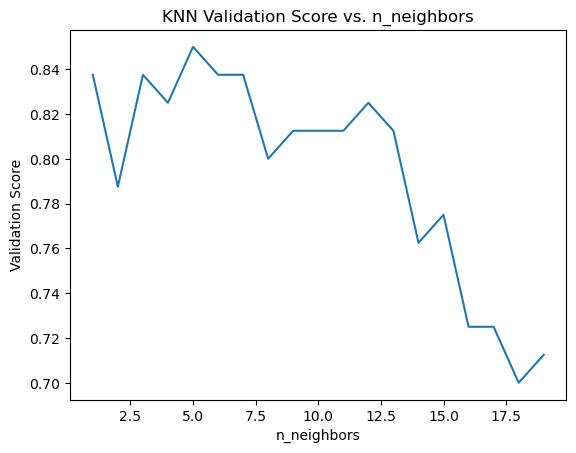

In [30]:
import matplotlib.pyplot as plt

# Get the results of the GridSearchCV
results = grid_KNN.cv_results_

# Get the test scores for each value of n_neighbors
test_scores = results['mean_test_score']

# Get the values of n_neighbors that were tested
n_neighbors = p_grid_KNN['n_neighbors']

# Plot the test scores as a function of n_neighbors
plt.plot(n_neighbors, test_scores)

# Add axis labels and title
plt.xlabel('n_neighbors')
plt.ylabel('Validation Score')
plt.title('KNN Validation Score vs. n_neighbors')

# Show the plot
plt.show()

### 3.5 Saving the data into the file

In [117]:
# Save the predictions to a CSV file
df_sub = pd.read_csv(Working_directory + 'SampleSubmission.csv')
for i in range(len(y_pred)):
    df_sub.loc[i, 'Category'] = y_pred[i]
df_sub.to_csv(Working_directory + 'SampleSubmission.csv', index=False)

### 3.6 Comparison of accuracies 

In [31]:
df_coef["KNN"] = pd.Series(grid_KNN.best_score_)

***
## 4. AdaBoost

### 4.1 Non-specific train and test datasets

In [40]:
# Load the dataset
X_train = df_train.drop(['Category', 'Id'], axis=1)
y_train = df_train['Category']

X_test = df_test.drop('Id', axis=1)

In [41]:
# Split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

### 4.2 Specific train and test datasets

In [35]:
# Select specific features in the dataset
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (Myocardium)', 'Myocardial thickness Mean (ED)',
                     'Myocardial thickness Std (ED)', 'Myocardial thickness Mean (ES)',
                     'Myocardial thickness Std (ES)', 'Ejection fraction (LV)', 'Ejection fraction (RV)']

In [36]:
# Load train and test sets
X_train = df_train[selected_features].values
y_train = df_train['Category'].values

X_test = df_test[selected_features].values

In [37]:
# Split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

### 4.3 Adaboost

In [42]:
# Define the Adaboost classifier
dtc = DecisionTreeClassifier(max_depth=1)
ada = AdaBoostClassifier(
    base_estimator=dtc, n_estimators=500, learning_rate=1.0, random_state=42)

# Train the model on the training set
ada.fit(X_train, y_train)

# Evaluate the performance on the validation set
score = ada.score(X_val, y_val)
print("Validation set accuracy: {:.2f}".format(score))

# Make predictions on the test set
y_pred = ada.predict(X_test)
print(y_pred)


Validation set accuracy: 0.50
[1 4 0 0 4 1 0 0 4 4 0 0 0 0 0 4 1 0 1 0 4 0 0 0 4 1 1 4 1 4 1 4 0 1 0 0 1
 0 1 0 1 1 1 1 4 1 0 1 1 1]


### Identifying key features

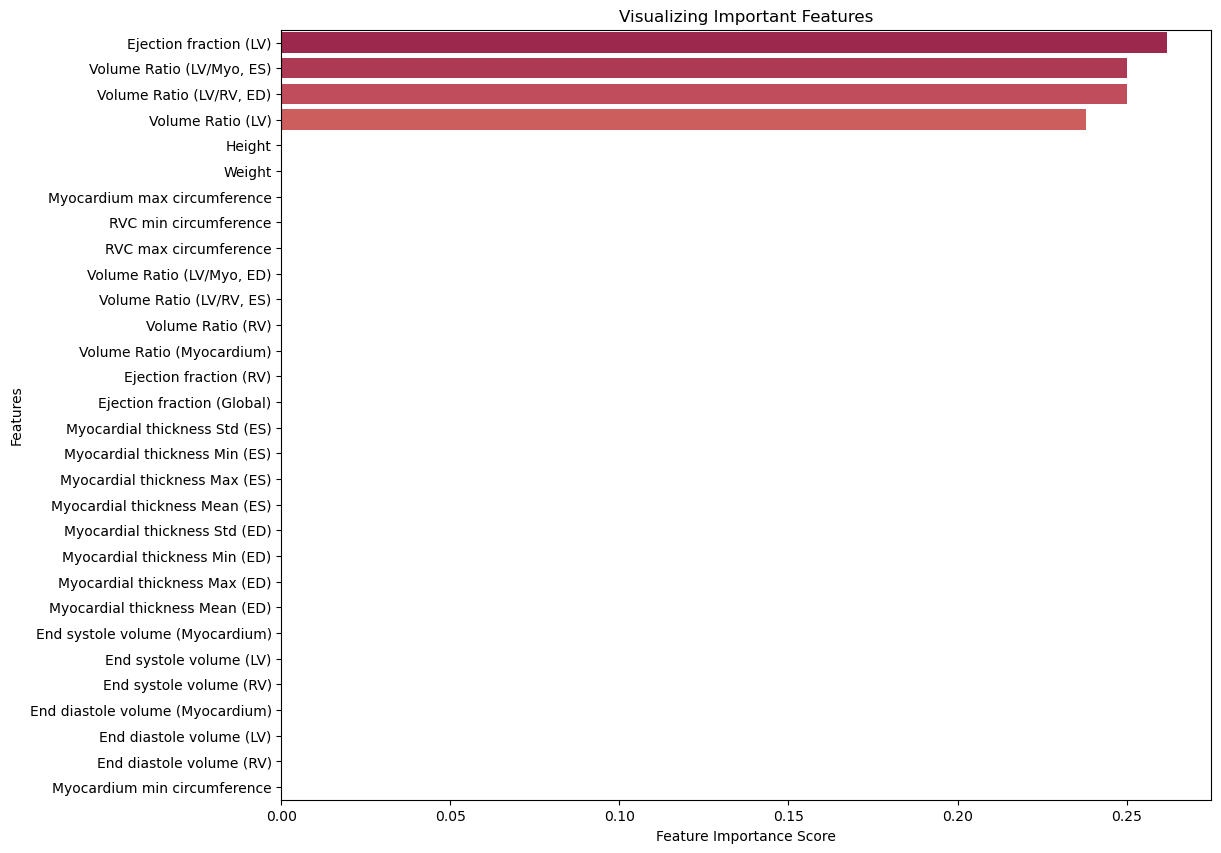

In [45]:
# Use this section with 4.1 train and test sets 

# Computing Feature importance scores
feature_imp = pd.Series(ada.feature_importances_, index=X_test.columns.unique()).sort_values(ascending=False)

# Plotting the scores
plt.figure(figsize=(12,10))

sns.barplot(x=feature_imp, y=feature_imp.index, palette='Spectral')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

plt.show()
plt.close()

### 4.4 Saving the data into the file

In [ ]:
# Save the predictions to a CSV file
df_sub = pd.read_csv(Working_directory + 'SampleSubmission.csv')
for i in range(len(y_pred)):
    df_sub.loc[i, 'Category'] = y_pred[i]
df_sub.to_csv(Working_directory + 'SampleSubmission.csv', index=False)

### 4.5 Comparison of accuracies 

In [46]:
df_coef["AdaBoost"] = pd.Series(score)

***
## 5. Partial article 2 : Multi-Layer Perceptron 

### 5.1 Non-specific train and test datasets

In [47]:
# Load the dataset
X_train = df_train.drop(['Category', 'Id'], axis=1)
y_train = df_train['Category']

X_test = df_test.drop('Id', axis=1)

In [48]:
# Split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

### 5.2 Specific train and test datasets

In [50]:
# Select specific features in the dataset
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)', 'Myocardial thickness Mean (ED)',
                     'Myocardial thickness Max (ED)', 'Myocardial thickness Min (ED)',
                     'Myocardial thickness Std (ED)', 'Myocardial thickness Mean (ES)',
                     'Myocardial thickness Max (ES)', 'Myocardial thickness Min (ES)',
                     'Myocardial thickness Std (ES)', 'Ejection fraction (Global)']

In [51]:
# Load the dataset
X_train = df_train[selected_features].values
y_train = df_train['Category'].values

X_test = df_test[selected_features].values

In [52]:
# Split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

### 5.3 Multi-Layer Perceptron inspired from the article

In [53]:
# Train MLPs
mlp_ensemble = []
for i in range(50):
    mlp = MLPClassifier(hidden_layer_sizes=(32, 32, 32, 32),
                        activation='relu',
                        alpha=0.0001,
                        batch_size='auto',
                        learning_rate='constant',
                        learning_rate_init=0.001,
                        max_iter=400,
                        shuffle=True,
                        random_state=i)

    # Randomly select 2/3 of the features for this MLP
    selected_features = np.random.choice(
        X_train.shape[1], size=int(2/3*X_train.shape[1]), replace=False)
    mlp.fit(X_train[:, selected_features], y_train)
    mlp_ensemble.append(mlp)


# Evaluate the MLP ensemble on the validation set
mlp_scores = []
for mlp in mlp_ensemble:
    mlp_scores.append(mlp.predict_proba(X_val[:, selected_features]))

mlp_scores = np.mean(np.array(mlp_scores), axis=0)
mlp_preds = np.argmax(mlp_scores, axis=1)

acc_val = accuracy_score(y_val, mlp_preds)
print(acc_val)

0.4


### 5.4 Saving the data into the file

In [55]:
# Save the predictions to a CSV file
df_sub = pd.read_csv(Working_directory + 'SampleSubmission.csv')
for i in range(len(y_pred)):
    df_sub.loc[i, 'Category'] = y_pred[i]
df_sub.to_csv(Working_directory + 'SampleSubmission.csv', index=False)

### 5.5 Comparison of accuracies 

In [54]:
df_coef["MLP"] = pd.Series(acc_val)

***
## 6. Random Forest

### 6.1 Non-specific train and test datasets

In [67]:
# Load the dataset
X_train = df_train.drop(['Category', 'Id'], axis=1)
y_train = df_train['Category']

X_test = df_test.drop('Id', axis=1)

In [68]:
# Split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2)

### 6.2 Specific train and test datasets (Used for LeaderBoard)

In [58]:
# Train and test sets used for my final SampleSubmission.cv of the Leaderboard 
selected_features = ['Height', 'Weight', 'End diastole volume (RV)',
                     'End diastole volume (LV)', 'End diastole volume (Myocardium)',
                     'End systole volume (RV)', 'End systole volume (LV)',
                     'End systole volume (Myocardium)', 'Myocardial thickness Mean (ED)',
                     'Myocardial thickness Max (ED)', 'Myocardial thickness Min (ED)',
                     'Myocardial thickness Std (ED)', 'Myocardial thickness Mean (ES)',
                     'Myocardial thickness Max (ES)', 'Myocardial thickness Min (ES)',
                     'Myocardial thickness Std (ES)', 'Ejection fraction (Global)',
                     'Volume Ratio (Myocardium)', 'Volume Ratio (LV)', 'Volume Ratio (RV)',
                     'Volume Ratio (LV/RV, ED)', 'Volume Ratio (LV/RV, ES)',
                     'Volume Ratio (LV/Myo, ED)', 'Volume Ratio (LV/Myo, ES)']

In [59]:
# Load the dataset
X_train = df_train[selected_features].values
y_train = df_train['Category'].values

X_test = df_test[selected_features].values

In [60]:
# Split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2)

### 6.3 Random Forest

#### 6.3.a Random Forest (n_estimators = 100) (Used for LeaderBoard)

In [29]:
# BE CAREFUL : the random_state is imported from a precedent version of the notebook, so if this cell is load again, then the y_pred may be a little bit different.
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print(rf.score(X_val, y_val))

y_pred = rf.predict(X_test)
print(y_pred)

0.9
[2 4 4 3 4 1 0 3 4 4 3 3 0 0 0 4 2 3 1 0 4 0 3 3 1 2 1 4 2 4 1 4 3 2 0 3 1
 3 1 0 2 1 2 1 4 2 0 1 1 1]


#### 6.3.b Random Forest (n_estimators = 150)

In [69]:
# With the non-specific train and test datasets
rf = RandomForestClassifier(n_estimators=150, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

print(rf.score(X_val, y_val))
print(classification_report(y_val, y_pred))

0.95
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.75      1.00      0.86         3
           2       1.00      0.86      0.92         7
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3

    accuracy                           0.95        20
   macro avg       0.95      0.97      0.96        20
weighted avg       0.96      0.95      0.95        20



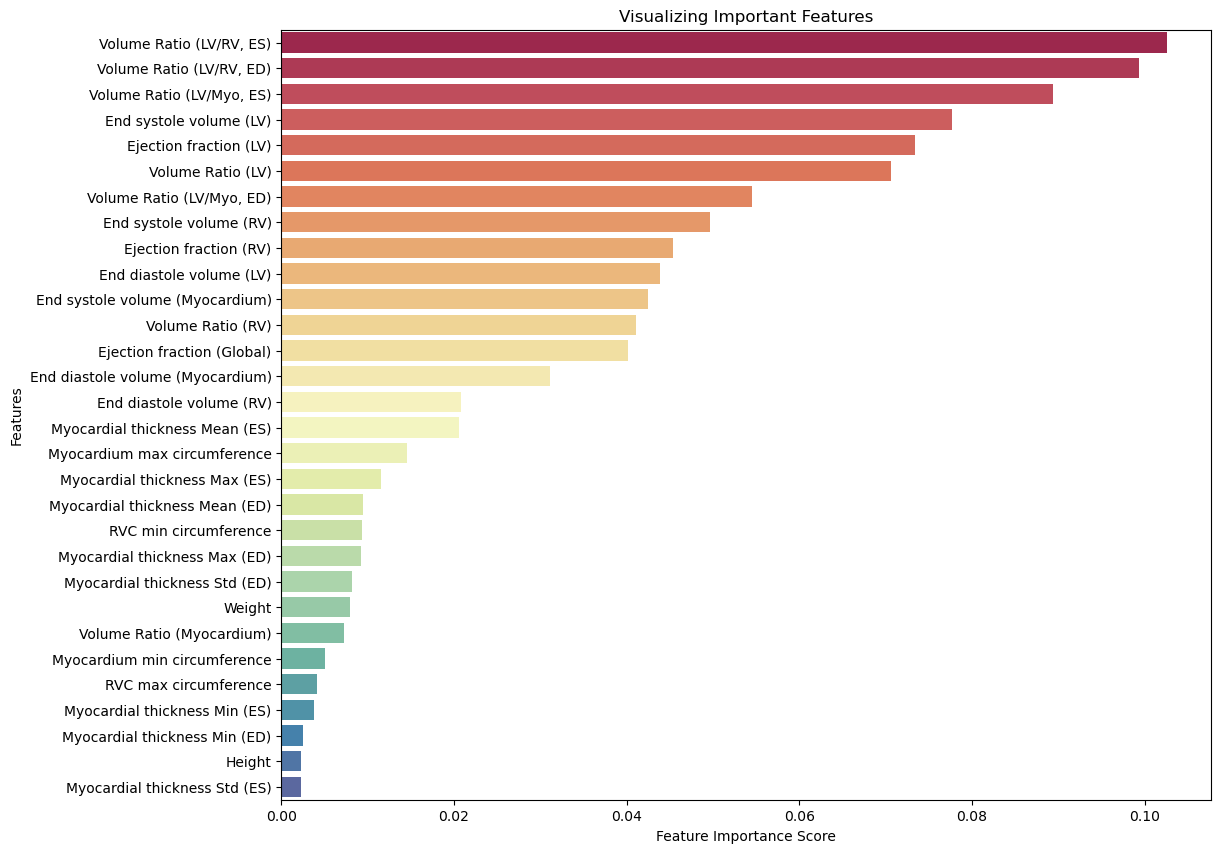

In [70]:
# Used with 6.1 train and test sets

# Computing Feature importance scores
feature_imp = pd.Series(rf.feature_importances_, index=X_test.columns.unique()).sort_values(ascending=False)

# Plotting the scores
plt.figure(figsize=(12,10))

sns.barplot(x=feature_imp, y=feature_imp.index, palette='Spectral')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

plt.show()
plt.close()

#### 6.3.c Random Forest (n_estimators = 1000)

In [156]:
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

print(rf.score(X_val, y_val))
print(classification_report(y_val, y_pred))

0.85
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.80      1.00      0.89         4
           2       1.00      0.86      0.92         7
           3       0.60      1.00      0.75         3
           4       1.00      1.00      1.00         3

    accuracy                           0.85        20
   macro avg       0.88      0.84      0.81        20
weighted avg       0.90      0.85      0.84        20



### 6.4 Tuning our hyperparameters - GridSearchCV

In [74]:
RF = RandomForestClassifier(random_state=0)
p_grid_RF = {: [10, 15, 20, 22, 23, 24, 25, 26, 27, 30, 100, 150, 300, 1000, 1500], 'min_samples_leaf': [
    2, 3, 4, 5, 6], 'max_features': ['sqrt', 'log2']}

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF,
                       scoring='accuracy', cv=5)
grid_RF.fit(X_train, y_train)

print("Best Validation Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

Best Validation Score: 0.9375
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 100}
Random Forest test score : 1.0


In [75]:
best_params = grid_RF.best_params_
RF = RandomForestClassifier(min_samples_leaf=best_params["min_samples_leaf"],
                            max_features=best_params["max_features"], n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train, y_train)
y_test = RF.predict(X_test)

In [76]:
y_pred = RF.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         3

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [77]:
y_pred = RF.predict(X_test)
print(y_pred)

[2 4 0 3 4 1 0 3 4 4 3 3 0 0 0 4 2 3 1 3 4 0 3 3 1 2 1 4 2 4 1 4 3 2 3 3 1
 3 2 0 2 1 2 1 4 2 3 1 1 1]


### 6.5 Saving the data into the file

In [ ]:
# Save the predictions to a CSV file
df_sub = pd.read_csv(Working_directory + 'SampleSubmission.csv')
for i in range(len(y_pred)):
    df_sub.loc[i, 'Category'] = y_pred[i]
df_sub.to_csv(Working_directory + 'SampleSubmission.csv', index=False)

### 6.6 Comparison of accuracies 

In [78]:
df_coef["RF"] = pd.Series(grid_RF.best_score_)

***
## 7. Sequential Feature Selection

### 7.1 Non-specific train and test datasets

In [79]:
# Load the dataset
X_train = df_train.drop(['Category', 'Id'], axis=1)
y_train = df_train['Category']

X_test = df_test.drop('Id', axis=1)

In [80]:
# Split the dataset into training and test sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

### 7.2 Sequential Feature Selection

In [81]:
# Define the sequential feature selector
sfs = SequentialFeatureSelector(RandomForestClassifier(
    n_estimators=100, random_state=42), n_features_to_select=10, direction='backward')

sfs.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[sfs.support_]

X_train = X_train[selecwted_features]
X_val = X_val[selected_features]
X_test = X_test[selected_features]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
print(classification_report(y_val, y_pred))

sfs_accuracy = accuracy_score(y_val, y_pred)
print(sfs_accuracy)

y_pred = rf.predict(X_test)
print(y_pred)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.50      0.67      0.57         3
           2       0.75      0.60      0.67         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         3

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20

0.85
[2 4 3 3 4 1 0 3 4 4 3 3 0 0 0 4 2 3 1 3 4 0 3 3 1 2 1 4 2 4 1 4 3 2 3 3 1
 3 1 0 2 1 2 1 4 2 3 1 1 1]


### Identifying key features

In [82]:
selected_features

Index(['End systole volume (RV)', 'Myocardial thickness Max (ES)',
       'Ejection fraction (RV)', 'Volume Ratio (LV)',
       'Volume Ratio (LV/RV, ED)', 'Volume Ratio (LV/RV, ES)',
       'Volume Ratio (LV/Myo, ED)', 'Volume Ratio (LV/Myo, ES)',
       'Myocardium max circumference', 'Myocardium min circumference'],
      dtype='object')

### 7.3 Saving the data into the file

In [ ]:
# Save the predictions to a CSV file
df_sub = pd.read_csv(Working_directory + 'SampleSubmission.csv')
for i in range(len(y_pred)):
    df_sub.loc[i, 'Category'] = y_pred[i]
df_sub.to_csv(Working_directory + 'SampleSubmission.csv', index=False)

### 7.4 Comparison of accuracies 

In [84]:
df_coef["SFS"] = pd.Series(sfs_accuracy)

***
## Conclusion

In [92]:
df_coef

,KNN,AdaBoost,MLP,RF,SFS
0,0.85,0.5,0.4,0.9375,0.85


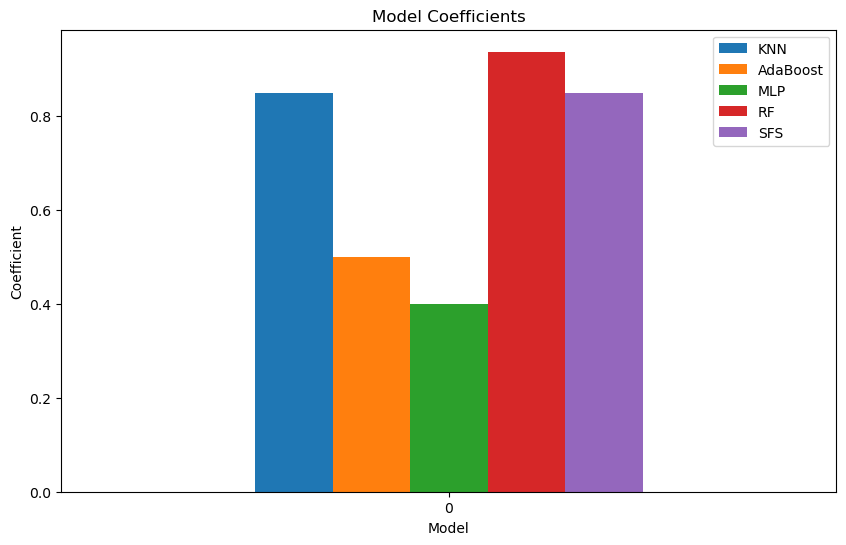

In [91]:
# plot the coefficients for each model
ax = df_coef.plot(kind='bar', figsize=(10, 6), rot=0)

# set the title and axis labels
ax.set_title('Model Coefficients')
ax.set_xlabel('Model')
ax.set_ylabel('Coefficient')

# display the plot
plt.show()